# Activation Foil Analysis: 1L BABY Run #6

This notebook processes the calibration data from NaI detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [ ]:
download_from_raw = False

In [2]:
import numpy as np
from datetime import datetime
import json

In [3]:
from process_foil_data import get_data
url = "https://zenodo.org/records/15794193/files/BABY_1L_Run6_250530.zip?download=1"
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw, url)


Read in properties of Nb Packet #3 foil
Read in properties of Zr Packet #1 foil
Directory already exists: ../../data/neutron_detection/activation_foils
Processing Co60 Count 1...
Processing Co60 Count 2...
Processing Cs137 Count 1...
Processing Cs137 Count 2...
Processing Mn54 Count 1...
Processing Mn54 Count 2...
Processing Na22 Count 1...
Processing Na22 Count 2...
Processing background...
Processing Nb Packet #3 Count 1...
Processing Nb Packet #3 Count 2...
Processing Zr Packet #1 Count 1...
Processing Zr Packet #1 Count 2...


## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

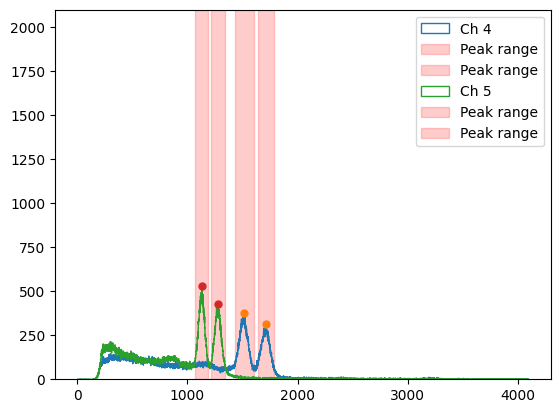

In [4]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass

for detector in check_source_measurements["Co60 Count 1"].detectors:
    hist, bin_edges = detector.get_energy_hist()

    plt.hist(
        bin_edges[:-1],
        bins=bin_edges,
        weights=hist,
        histtype="step",
        label=f"Ch {detector.channel_nb}",
    )
    peaks = check_source_measurements["Co60 Count 2"].get_peaks(hist)

    from scipy.signal import find_peaks
    import numpy as np

    start_index = 400
    height = 0.60 * np.max(hist[start_index:])
    prominence = None
    width = [10, 150]
    distance = 30
    peaks, peak_data = find_peaks(
        hist[start_index:],
        prominence=prominence,
        height=height,
        width=width,
        distance=distance,
    )
    plt.plot(bin_edges[start_index:][peaks], peak_data["peak_heights"], ".", ms=10)

    for i, p in enumerate(peaks):
        width = peak_data["widths"][i]
        plt.axvspan(
            bin_edges[start_index:][p] - width,
            bin_edges[start_index:][p] + width,
            color="red",
            alpha=0.2,
            label="Peak range",
        )

plt.legend()
# plt.yscale("log")
plt.ylim(top=2100)
plt.show()

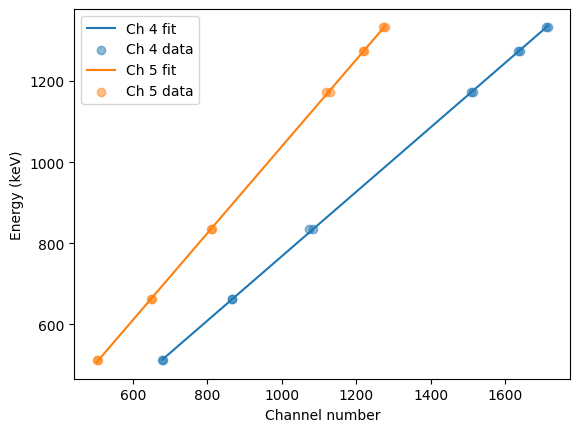

In [5]:
calibration_coeffs = {}

for channel_nb in [4, 5]:
    calibration_channels, calibration_energies = compass.get_calibration_data(
        check_source_measurements.values(),
        background_measurement=background_meas,
        channel_nb=channel_nb,
    )

    coeff = np.polyfit(calibration_channels, calibration_energies, 1)
    calibration_coeffs[channel_nb] = coeff

    xs = np.linspace(
        calibration_channels[0],
        calibration_channels[-1],
    )
    plt.plot(
        xs,
        np.polyval(coeff, xs),
        label=f"Ch {channel_nb} fit",
    )
    plt.scatter(
        calibration_channels,
        calibration_energies,
        label=f"Ch {channel_nb} data",
        alpha=0.5,
    )
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [6]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

Ch 4 
	 Energies: [ 511.     511.     661.657  661.657  834.848  834.848 1173.228 1173.228
 1274.537 1274.537 1332.492 1332.492], 
	 Efficiencies: [0.02102159 0.02749373 0.01978268 0.0208609  0.01482226 0.01623395
 0.01022607 0.01069233 0.01084041 0.0114625  0.00938804 0.00976438]
[-401.55899566  179.78226718  -26.92421218    1.33498439]
Ch 5 
	 Energies: [ 511.     511.     661.657  661.657  834.848  834.848 1173.228 1173.228
 1274.537 1274.537 1332.492 1332.492], 
	 Efficiencies: [0.03575154 0.02787124 0.02780254 0.02642409 0.02142706 0.01975958
 0.01441652 0.01376862 0.01492938 0.01429497 0.01279407 0.01204011]
[-387.1779018   172.86445791  -25.80281142    1.27486728]


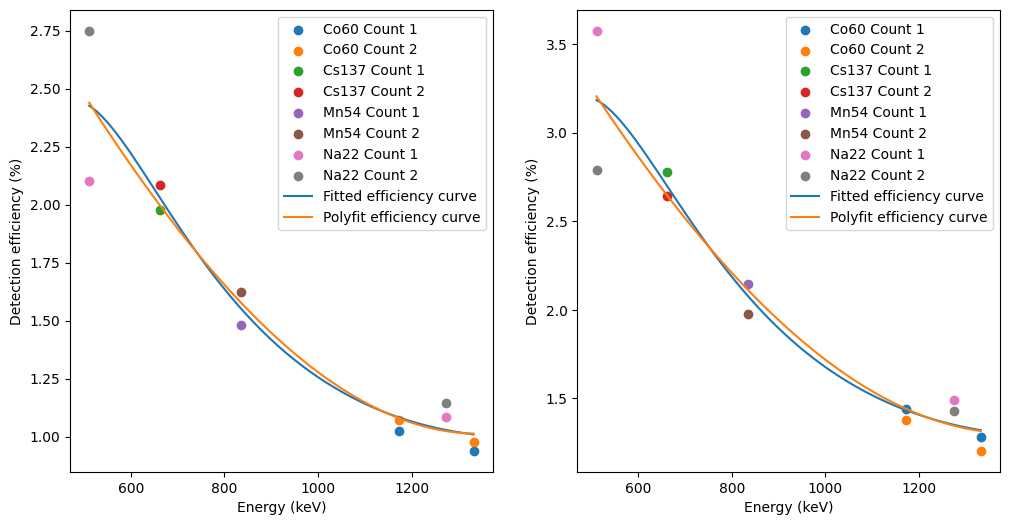

In [7]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements.values())[0]
search_width = 330

for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas.get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in check_source_measurements.items():
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas,
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=search_width,
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 3)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [8]:
all_neutron_rates = []
all_neutron_rates_err = []

In [9]:
from process_foil_data import irradiations, time_generator_off

### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the 1st measurement of the Niobium Packet #3 after irradiation is used to calculate the neutron rate of the overall irradiation. 

In [10]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Nb Packet #3"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=search_width)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])


Count 1
	 Ch 4: Neutron rate: 1.400e+09 +/- 1.161e+07 n/s
	 Ch 5: Neutron rate: 1.345e+09 +/- 9.816e+06 n/s
Count 2
	 Ch 4: Neutron rate: 1.384e+09 +/- 1.695e+07 n/s
	 Ch 5: Neutron rate: 1.450e+09 +/- 1.496e+07 n/s


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the 1st measurement of the Zirconium Packet #1 after irradiation is used to calculate the neutron rate of the overall irradiation. 

In [11]:
foil_name = "Zr Packet #1"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=search_width)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

Count 1
	 Ch 4: Neutron rate: 1.207e+09 +/- 5.711e+06 n/s
	 Ch 5: Neutron rate: 1.182e+09 +/- 4.875e+06 n/s
Count 2
	 Ch 4: Neutron rate: 1.186e+09 +/- 6.462e+06 n/s
	 Ch 5: Neutron rate: 1.178e+09 +/- 5.557e+06 n/s


The gamma spectrum obtained from the 2nd measurement of the Zirconium Packet #1 after irradiation is used to calculate the neutron rate of the overall irradiation. 

### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [12]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

Average neutron rate: 1.291e+09 ± 1.144e+08 n/s


In [13]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")

Processed data stored in ../../data/processed_data.json
